In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xagg

In [15]:
coap_mun = gpd.read_file(r'/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/municipality_data/caop_MUN/Cont_Mun_CAOP2023.shp')
coap_mun = coap_mun.to_crs("EPSG:4326")

In [16]:
west, south, east, north = coap_mun.total_bounds
PORTUGAL_BBOX = {
    "min_lat": south,  # Minimum latitude
    "max_lat": north,  # Maximum latitude
    "min_lon": west,   # Minimum longitude
    "max_lon": east    # Maximum longitude
}


In [10]:
coap_mun.head()

,fid,DICO,Municipio,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry
0,1.0,0101,Águeda,Aveiro,11.0,Região de Aveiro,Centro,Continente,762.0,4.0,33527.44,105.0,"POLYGON ((-20560.758 113803.912, -20550.798 11..."
1,2.0,0102,Albergaria-a-Velha,Aveiro,6.0,Região de Aveiro,Centro,Continente,425.0,0.0,15882.50,82.0,"POLYGON ((-26966.491 123573.381, -26964.759 12..."
2,3.0,0103,Anadia,Aveiro,10.0,Região de Aveiro,Centro,Continente,525.0,13.0,21663.48,75.0,"POLYGON ((-17449.514 93729.645, -17450.254 937..."
3,4.0,0104,Arouca,Aveiro,16.0,Área Metropolitana do Porto,Norte,Continente,1222.0,50.0,32910.52,118.0,"POLYGON ((-7133.618 149431.412, -7096.198 1494..."
4,5.0,0105,Aveiro,Aveiro,10.0,Região de Aveiro,Centro,Continente,78.0,0.0,19757.57,77.0,"POLYGON ((-42619.981 117138.132, -42536.222 11..."


In [ ]:
# 2) Dissolve municipalities up to the district level
districts_gdf = coap_mun.dissolve(
    by="Distrito",          # group key
    as_index=False,         # keep 'distrito' as a column
    aggfunc="first"         # how to aggregate non-geometry columns (adjust as needed)
)
# Get centroids


<Axes: >

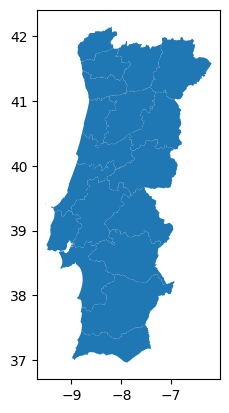

In [19]:
districts_gdf.plot()

## Climate Points Load

### Fire

#### Fire 79-21

In [20]:
fwi_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/fire/fire_weather_index_portugal_1979_2021.parquet')

In [22]:
high_fire_days = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/fire/high_fire_days_portugal_1979_2021.parquet')

#### 22 - 23

In [27]:
import os

# Folder with GRIB files
folder = "/Volumes/Dhruv_External_Disk/climate_data/fire/raw/fwi"

dfs = []

for file in os.listdir(folder):
    if file.endswith(".grib") or file.endswith(".grb"):
        path = os.path.join(folder, file)
        ds = xr.open_dataset(path, engine="cfgrib")

        # Drop unneeded variables if present
        for var in ["step", "surface", "valid_time"]:
            if var in ds:
                ds = ds.drop_vars(var)

        # Rename variable fwinx -> fwi
        if "fwinx" in ds:
            ds = ds.rename({"fwinx": "fwi"})

        # Convert to dataframe (multi-index -> columns)
        df = ds.to_dataframe().reset_index()

        # Filter by bbox
        df = df[
            (df["latitude"] >= PORTUGAL_BBOX["min_lat"]) &
            (df["latitude"] <= PORTUGAL_BBOX["max_lat"]) &
            (df["longitude"] >= PORTUGAL_BBOX["min_lon"]) &
            (df["longitude"] <= PORTUGAL_BBOX["max_lon"])
        ]

        dfs.append(df)

# Concatenate all files
df_all = pd.concat(dfs, ignore_index=True)

# Export to parquet
df_all.to_parquet("/Volumes/Dhruv_External_Disk/climate_data/fire/fwi_portugal_22_24.parquet", index=False)
print("Saved daily_fwi.parquet")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Saved daily_fwi.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [34]:

# Load parquet
df = pd.read_parquet("/Volumes/Dhruv_External_Disk/climate_data/fire/fwi_portugal_22_24.parquet")


# Monthly average FWI per gridpoint
monthly_avg = (
    df
    .groupby([
        pd.Grouper(key="time", freq="M"),
        "latitude",
        "longitude"
    ])["fwi"]
    .mean()
    .reset_index()
)

# Monthly count of high fire days (FWI > 30)
monthly_highfire = (
    df.assign(high_fire=(df["fwi"] > 30).astype(int))
    .groupby([
        pd.Grouper(key="time", freq="M"),
        "latitude",
        "longitude"
    ])["high_fire"]
    .sum()
    .reset_index()
    .rename(columns={"high_fire": "high_fire_days"})
)
monthly_avg["time"] = monthly_avg["time"].dt.to_period("M").dt.to_timestamp()
monthly_highfire["time"] = monthly_highfire["time"].dt.to_period("M").dt.to_timestamp()

# Save outputs
monthly_avg.to_parquet("/Volumes/Dhruv_External_Disk/climate_data/fire/fwi_monthly_pt_22_24.parquet", index=False)
monthly_highfire.to_parquet("/Volumes/Dhruv_External_Disk/climate_data/fire/monthly_pt_22_24_highfire_days.parquet", index=False)

print("Saved monthly_avg_fwi.parquet and monthly_highfire_days.parquet")


Saved monthly_avg_fwi.parquet and monthly_highfire_days.parquet


In [32]:
fwi_df

,time,lon,lat,fwi
9292,1979-01-01,-9.50,37.00,0.000000
9293,1979-01-01,-9.50,37.25,0.000000
9294,1979-01-01,-9.50,37.50,0.000000
9295,1979-01-01,-9.50,37.75,0.000000
9296,1979-01-01,-9.50,38.00,0.000000
...,...,...,...,...
25831238,2021-12-01,-6.25,41.00,1.074700
25831239,2021-12-01,-6.25,41.25,0.946599
25831240,2021-12-01,-6.25,41.50,1.425238
25831241,2021-12-01,-6.25,41.75,2.211312


In [36]:
fwi_df = fwi_df.rename(columns={'lon':'longitude', 'lat':'latitude'})
fwi_df = pd.concat([fwi_df, monthly_avg])

In [37]:
high_fire_days = fwi_df.rename(columns={'lon':'longitude', 'lat':'latitude'})
high_fire_days = pd.concat([fwi_df, monthly_highfire])

In [38]:
# Ensure datetime
fwi_df["time"] = pd.to_datetime(fwi_df["time"])
high_fire_days["time"] = pd.to_datetime(high_fire_days["time"])

# Filter by date range
mask1 = (fwi_df["time"] >= "2000-01-01") & (fwi_df["time"] <= "2023-12-01")
mask2 = (high_fire_days["time"] >= "2000-01-01") & (high_fire_days["time"] <= "2023-12-01")

fwi_df = fwi_df.loc[mask1]
high_fire_days = high_fire_days.loc[mask2]

In [ ]:
high_fire_days = high_fire_days.drop(columns=['fwi'])

fwi_df = fwi_df.reset_index().drop(columns=['index'])
high_fire_days = high_fire_days.reset_index().drop(columns=['index'])

In [91]:
def df_to_unique_ds(df, lat="latitude", lon="longitude", time="time",
                    round_decimals=4, agg="mean"):
    df = df.copy()
    df[time] = pd.to_datetime(df[time])
    # optional: snap coords to grid to avoid 1e-15 drift
    df[lat] = df[lat].round(round_decimals)
    df[lon] = df[lon].round(round_decimals)
    # collapse duplicates across all numeric columns
    df = (df.groupby([time, lat, lon], as_index=False)
            .agg(agg, numeric_only=True))
    return xr.Dataset.from_dataframe(df.set_index([time, lat, lon]).sort_index())

# use it
fire_ds = [df_to_unique_ds(df) for df in [fwi_df, high_fire_days]]

In [92]:
# Convert to xarray
fwi_agg = [
    xagg.aggregate(ds, xagg.pixel_overlaps(ds, districts_gdf)).to_dataframe()
    for ds in fire_ds]



creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
Found 20 break(s)/jump(s) in lat (i.e., grid doesn't cover whole planet); replacing grid cell width(s) with preceding grid cell width(s) at breakpoint.
Found 13 break(s)/jump(s) in lon (i.e., grid doesn't cover whole planet); replacing grid cell width(s) with preceding grid cell width(s) at breakpoint.
calculating overlaps between pixels and output polygons...
success!
aggregating fwi...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
Found 20 break(s)/jump(s) in lat (i.e., grid doesn't cover whole planet); replacing grid cell width(s) with preceding grid cell width(s) at breakpoint.
Found 13 break(s)/jump(s) in lon (i.e., grid doesn't cover whole planet); replacing grid cell width(s) with preceding grid cell width(s) at breakpoint.
calculating overlaps between pixels and output polygons...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xagg/auxfuncs.py:167: SomeNanWarning: One or more grid cells in variable fwi have inconsistent nans along the dimension(s) time (i.e., one or more grid cells are nan for some but not all coordinates of the dimension(s)). This means that grid cell weights will be different for different coordinates along time. The aggregation calculation may therefore be incorrect, since it aggregates over different grid cells for  the same polgyon for different coordinates of the dimension(s)time.
  warnings.warn('One or more grid cells in variable '+var+' have inconsistent nans along the dimension(s) '+


success!
aggregating high_fire_days...
all variables aggregated to polygons!


### Temperature

In [93]:
heatwaves_df = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_data/heatwaves_portugal_1940_2023.parquet')
frost_df = pd.read_parquet('/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_data/frost_portugal_1940_2023.parquet')
hot_days = pd.read_parquet('/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_data/hot_days_portugal_1940_2023.parquet')
tropical_df = pd.read_parquet('/Volumes/Dhruv_External_Disk/climate_data/temperature/monthly_data/tropical_nights_portugal_1940_2023.parquet')
temp_df = [heatwaves_df, frost_df, hot_days, tropical_df]
# Filter each df in place
temp_df = [
    df.loc[(df["time"] >= "2000-01-01") & (df["time"] <= "2023-12-01")]
    for df in [heatwaves_df, frost_df, hot_days, tropical_df]
]
# assuming each df has columns: ["time", "latitude", "longitude", ...metrics...]
temp_ds = [
    xr.Dataset.from_dataframe(
        df.assign(time=pd.to_datetime(df["time"]))
          .set_index(["time", "lat", "lon"])
          .sort_index()
    )
    for df in temp_df
]
# Convert to xarray
temp_agg = [
    xagg.aggregate(ds, xagg.pixel_overlaps(ds, districts_gdf)).to_dataframe()
    for ds in temp_ds]



creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating num_heatwaves...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating frost_days...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating hot_days...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating num_tropical_nights...
all variables aggregated to polygons!


### Rain

In [94]:
#tp_99 = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/_tp99_thresholds.parquet')
cdd = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/dry_days_portugal_1940_2023_25DEG.parquet')
max_5 = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/max_5_day_.parquet')
ex_tp_tot = pd.read_parquet(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/extreme_tp_tot.parquet')
# Filter each df in place
tp_sources = [
    df.rename(columns={"lat": "latitude", "lon": "longitude", 'month':'time'})
    if any(col in df.columns for col in ["lat", "lon", 'month']) else df
    for df in [cdd, max_5, ex_tp_tot]
]
bbox = PORTUGAL_BBOX  # uses min_lat/max_lat/min_lon/max_lon

tp_ds = []
for df in tp_sources:
    df = df.assign(time=pd.to_datetime(df["time"], utc=False))
    df = df.loc[
        df["time"].between("2000-01-01", "2023-12-01") &
        df["latitude"].between(bbox["min_lat"], bbox["max_lat"]) &
        df["longitude"].between(bbox["min_lon"], bbox["max_lon"])
    ]
    ds = xr.Dataset.from_dataframe(
        df.set_index(["time", "latitude", "longitude"]).sort_index()
    )
    tp_ds.append(ds)

# aggregate each dataset; returns DataFrames
tp_agg = [
    xagg.aggregate(ds, xagg.pixel_overlaps(ds, districts_gdf)).to_dataframe()
    for ds in tp_ds
]



creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating cdd...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating max_5_day_...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating extreme_tp_tot...
all variables aggregated to polygons!


## Merge

In [ ]:
from functools import reduce

lists_of_dfs = [fwi_agg, tp_agg, temp_agg]

drop_cols = ['fid', 'DICO', 'Municipio', 'N_Freguesi', 'NUTSIII',
             'NUTSII', 'NUTSI', 'Alt_Max', 'Alt_Min', 
             'Area_ha', 'Perim_km', 'poly_idx', 'index']  # add 'index'

key_cols = ["time", "Distrito"]

all_dfs = []
for i, dfs in enumerate(lists_of_dfs):
    for j, df in enumerate(dfs):
        # reset once
        df = df.reset_index()
        # drop junk cols
        df = df.drop(columns=[c for c in drop_cols if c in df.columns])
        # identify value cols
        value_cols = [c for c in df.columns if c not in key_cols]
        all_dfs.append(df[key_cols + [f"{c}" for c in value_cols]])

merged = reduce(
    lambda left, right: pd.merge(left, right, on=key_cols, how="outer"),
    all_dfs
)

print(merged.shape)
print(merged.columns)


(5184, 11)
Index(['time', 'Distrito', 'fwi', 'high_fire_days', 'cdd', 'max_5_day_',
       'extreme_tp_tot', 'num_heatwaves', 'frost_days', 'hot_days',
       'num_tropical_nights'],
      dtype='object')


In [107]:
# ensure datetime
merged["time"] = pd.to_datetime(merged["time"])

# get year column
merged["year"] = merged["time"].dt.year

value_cols = [c for c in merged.columns if c not in ["time", "year", "Distrito"]]

# annual average
annual_mean = (
    merged.groupby(["year", "Distrito"], as_index=False)[value_cols]
          .mean()
)

# annual median
annual_median = (
    merged.groupby(["year", "Distrito"], as_index=False)[value_cols]
          .median()
)

# annual sum
annual_sum = (
    merged.groupby(["year", "Distrito"], as_index=False)[value_cols]
          .sum()
)


In [110]:
print(os.getcwd())

/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/yearly_20_23


In [118]:

annual_mean.to_excel(f"annual_mean_weather.xlsx")
annual_median.to_excel(f"annual_median_weather.xlsx")
annual_sum.to_excel(f"annual_sum_weather.xlsx")